In [42]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt as bwdist
from grid import create_grid

In [43]:
# data
ind = np.random.randint(0, 214)
elev_map = np.load('./data/elev_map{}.npy'.format(ind))
dynamic_pc = np.load('./data/dynamic_pc{}.npy'.format(ind))
robot_pose = np.load('./data/robot_pose{}.npy'.format(ind))
x_min, y_min = np.min(elev_map[:, 0]), np.min(elev_map[:, 1])

# local elevation map params
map_res = 0.15
margin = 0.1
unexplored_value = 0.25
safety_distance = 2*map_res
# APF params
max_apf_iters = 300
influence_r = 0.2
repulsive_coef = 200
attractive_coef = 1./100

In [44]:
grid, elev_grid = create_grid(elev_map, robot_pose[2], map_res, margin, safety_distance, unexplored_value)

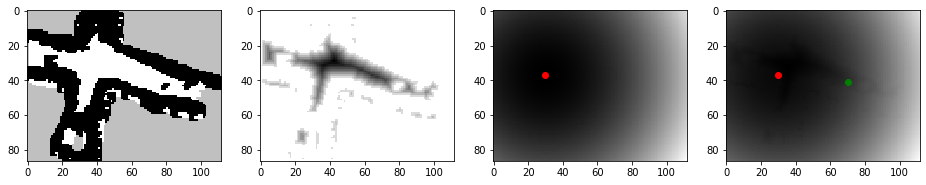

In [45]:
nrows, ncols = grid.shape
x, y = np.meshgrid(np.arange(ncols), np.arange(nrows))
# Compute repulsive force
d = bwdist(grid==0)
# Rescale and transform distances
d2 = d/100. + 1
d0 = 1 + influence_r
nu = repulsive_coef
repulsive = nu*((1./d2 - 1./d0)**2)
repulsive[d2 > d0] = 0


# Compute attractive force
start = (np.array([robot_pose[1], robot_pose[0]]) - [y_min, x_min]) // map_res
while True:
    i,j = np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1])
    if grid[i,j] != 1:
        goal = [j, i]
        break
# goal = [90, 10]
xi = attractive_coef
attractive = xi * ( (x - goal[0])**2 + (y - goal[1])**2 )
# Combine terms
total = attractive + repulsive

plt.figure(figsize=(16,5))
plt.subplot(1,4,1)
plt.imshow(1-grid, cmap='gray')

plt.subplot(1,4,2)
plt.imshow(repulsive, cmap='gray')

plt.subplot(1,4,3)
plt.imshow(attractive, cmap='gray')
plt.plot(goal[0], goal[1], 'ro')

plt.subplot(1,4,4)
plt.imshow(total, cmap='gray')
plt.plot(goal[0], goal[1], 'ro')
plt.plot(start[0], start[1], 'ro', color='g')

In [46]:
def construct_path(total_potential, start_coords, end_coords, max_its):
    # construct_path: This function plans a path through a 2D
    # environment from a start to a destination based on the gradient of the
    # function f which is passed in as a 2D array. The two arguments
    # start_coords and end_coords denote the coordinates of the start and end
    # positions respectively in the array while max_its indicates an upper
    # bound on the number of iterations that the system can use before giving
    # up.
    # The output, route, is an array with 2 columns and n rows where the rows
    # correspond to the coordinates of the robot as it moves along the route.
    # The first column corresponds to the x coordinate and the second to the y coordinate
    gy, gx = np.gradient(-total_potential)
    route = [np.array(start_coords)]
    for i in range(max_its):
        current_point = np.array(route[-1])
        #print(sum( abs(current_point-end_coords) ))
        if sum( abs(current_point-end_coords) ) < 2.0:
            print('APF: reached the goal !')
            break
        ix = np.clip(int(current_point[1]), 0, gx.shape[0]-1)
        iy = np.clip(int(current_point[0]), 0, gx.shape[1]-1)
        vx = gx[ix, iy]; vy = gy[ix, iy]
        dt = 1/(1e-8+np.linalg.norm([vx, vy]))
        next_point = current_point + dt/2.*np.array([np.sign(vx)*vx**2, np.sign(vy)*vy**2])
        #next_point = current_point + dt*np.array( [vx, vy] ) + dt/2.*np.array([np.sign(vx)*vx**2, np.sign(vy)*vy**2])
        route.append(next_point)
    return route

In [47]:
def draw_gradient(f, skip=1):
    nrows, ncols = f.shape
    x_m, y_m = np.meshgrid(np.arange(ncols), np.arange(nrows))
    gy, gx = np.gradient(-f)
    Q = plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], -gy[::skip, ::skip])

In [48]:
path = construct_path(total, start, goal, max_its=max_apf_iters)
path = np.array(path)

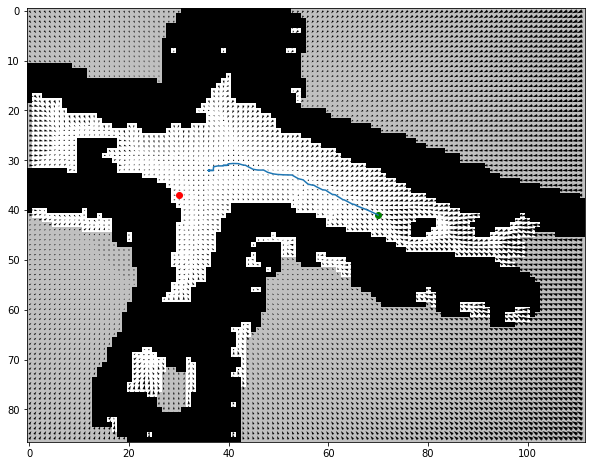

In [49]:
plt.figure(figsize=(10,10))
draw_gradient(total)
plt.plot(goal[0], goal[1], 'ro')
plt.plot(start[0], start[1], 'ro', color='g')
plt.plot(path[:,0], path[:,1])
plt.imshow(1-grid, cmap='gray')

### Transform path to robot coordinate frame, [m]

In [50]:
def apf_planner(grid, start, goal, num_iters=500, influence_r=0.2, repulsive_coef=200, attractive_coef=0.01):
    nrows, ncols = grid.shape
    x, y = np.meshgrid(np.arange(ncols), np.arange(nrows))
    # Compute repulsive force
    d = bwdist(grid==0)
    # Rescale and transform distances
    d2 = d/100. + 1
    d0 = 1 + influence_r
    nu = repulsive_coef
    repulsive = nu*((1./d2 - 1./d0)**2)
    repulsive[d2 > d0] = 0

    # Compute attractive force
    xi = attractive_coef
    attractive = xi * ( (x - goal[0])**2 + (y - goal[1])**2 )
    # Combine terms
    total_potential = attractive + repulsive
    # plan a path
    path = construct_path(total_potential, start, goal, num_iters)
    return path, total_potential

In [51]:
path_grid, total_potential = apf_planner(grid, start, goal, max_apf_iters, influence_r, repulsive_coef, attractive_coef)
path_grid = np.array(path_grid)

# plt.figure(figsize=(10,10))
# plt.imshow(1-grid, cmap='gray')
# plt.plot(goal[0], goal[1], 'ro')
# plt.plot(start[0], start[1], 'ro', color='g')
# plt.plot(path_grid[:,0], path_grid[:,1])
# draw_gradient(total_potential)

In [52]:
def apf_path_to_map(apf_path, elev_map, elev_grid, map_res=0.15):
    path_map = []
    x_min, y_min = np.min(elev_map[:, 0]), np.min(elev_map[:, 1])
    for point in apf_path:
        z = elev_grid[int(point[1]), int(point[0])]
        p = (np.array(point)*map_res+[y_min, x_min]).tolist() + [z]
        path_map.append([p[1], p[0], p[2]])
    return path_map

In [53]:
path_map = apf_path_to_map(path_grid, elev_map, elev_grid, map_res)

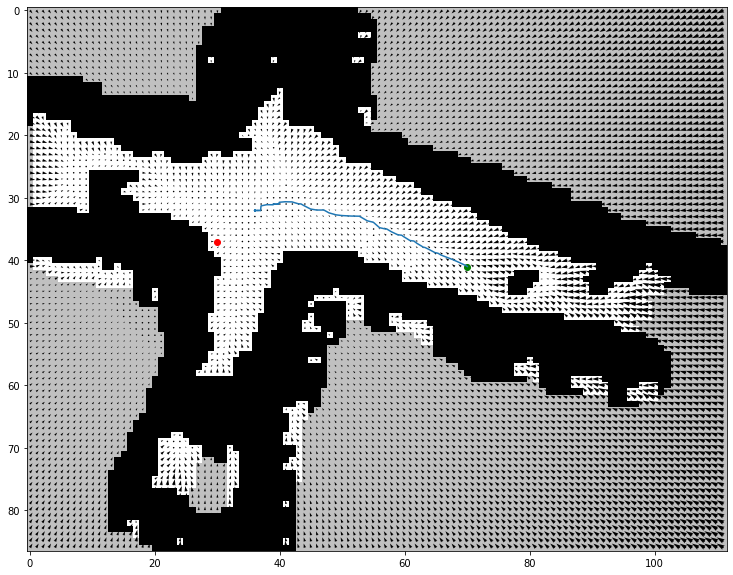

In [54]:
# visualize everithing
X = elev_map[:,0]; Y = elev_map[:,1]; Z = elev_map[:,2]
dZ = Z - robot_pose[2]
plt.figure(figsize=(20,10))
# plt.subplot(1,2,1)
# plt.plot(X[dZ<=margin], Y[dZ<=margin], 's', color='green', label='traversable', markersize=15)
# plt.plot(X[dZ>margin], Y[dZ>margin], 's', color='red', label='obstacles', markersize=15)
# plt.plot(robot_pose[0], robot_pose[1], 'v', color='k', markersize=10, label='robot')
# path_map = np.array(path_map)
# plt.plot(path_map[:,0], path_map[:,1], color='b', linewidth=4, label='path')
# plt.title('Height margin = %.2f'%margin)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.grid()

# plt.subplot(1,2,2)
plt.imshow(1-grid, cmap='gray')
plt.plot(goal[0], goal[1], 'ro')
plt.plot(start[0], start[1], 'ro', color='g')
plt.plot(path_grid[:,0], path_grid[:,1])
draw_gradient(total_potential)

plt.show()